In [6]:
!pip -q install ultralytics opencv-python pillow

from ultralytics import YOLO
from google.colab.output import eval_js
from IPython.display import Javascript, display
from google.colab.patches import cv2_imshow

import cv2, base64, io, time
import numpy as np
from PIL import Image


In [7]:
js_code = r"""
async function takePhoto() {
  // Create hidden video element
  const video = document.createElement('video');
  video.setAttribute('autoplay','');
  video.setAttribute('playsinline','');
  video.style.position = 'fixed';
  video.style.right = '-9999px';
  document.body.appendChild(video);

  // Ask for camera permission and start stream
  const stream = await navigator.mediaDevices.getUserMedia({ video: true, audio: false });
  video.srcObject = stream;

  // Wait until video metadata is loaded
  await new Promise(resolve => { video.onloadedmetadata = resolve; });
  await video.play();

  // Draw the current frame to a canvas
  const canvas = document.createElement('canvas');
  canvas.width = video.videoWidth || 640;
  canvas.height = video.videoHeight || 480;
  const ctx = canvas.getContext('2d');
  ctx.drawImage(video, 0, 0, canvas.width, canvas.height);

  // Stop camera and cleanup
  try { stream.getTracks().forEach(t => t.stop()); } catch(e) {}
  video.remove();

  // Return JPEG base64 data URL
  return canvas.toDataURL('image/jpeg', 0.9);
}
"""
display(Javascript(js_code))
print("✅ takePhoto() injected. If asked, allow camera access in the browser.")


<IPython.core.display.Javascript object>

✅ takePhoto() injected. If asked, allow camera access in the browser.


In [8]:
def js_to_image(js_reply: str):
    """Convert JS dataURL -> OpenCV BGR image (numpy array)."""
    if not js_reply or ',' not in js_reply:
        return None
    image_bytes = base64.b64decode(js_reply.split(',')[1])
    image_pil = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    image_np = np.array(image_pil)
    frame_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    return frame_bgr

def capture_js_image(retries=2, wait_after_inject=0.6):
    """
    Call takePhoto() in frontend. If takePhoto isn't defined (ReferenceError),
    reinject the JS and retry up to `retries` times.
    """
    for attempt in range(1, retries+1):
        try:
            js_reply = eval_js('takePhoto()')
            return js_reply
        except Exception as e:
            err_str = str(e)
            if 'takePhoto is not defined' in err_str or 'ReferenceError' in err_str:
                print(f"⚠️ takePhoto not defined in frontend (attempt {attempt}/{retries}). Reinjection...")
                display(Javascript(js_code))
                time.sleep(wait_after_inject)
                continue
            else:
                raise
    raise RuntimeError("Failed to capture image from frontend after reinjecting JS.")


In [9]:
model = YOLO('yolov8s.pt')
print("✅ Loaded YOLOv8 model (yolov8s).")


✅ Loaded YOLOv8 model (yolov8s).



📸 Capturing image 1/2 ... (please allow camera if prompted)
⚠️ takePhoto not defined in frontend (attempt 1/3). Reinjection...


<IPython.core.display.Javascript object>


0: 480x640 1 person, 13.4ms
Speed: 2.1ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


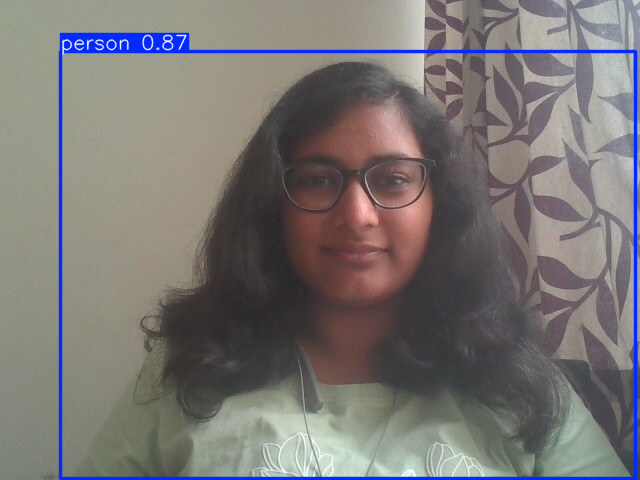

💾 Saved: yolo_output_1.jpg

📸 Capturing image 2/2 ... (please allow camera if prompted)

0: 480x640 1 person, 1 remote, 1 cell phone, 16.2ms
Speed: 1.7ms preprocess, 16.2ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 640)


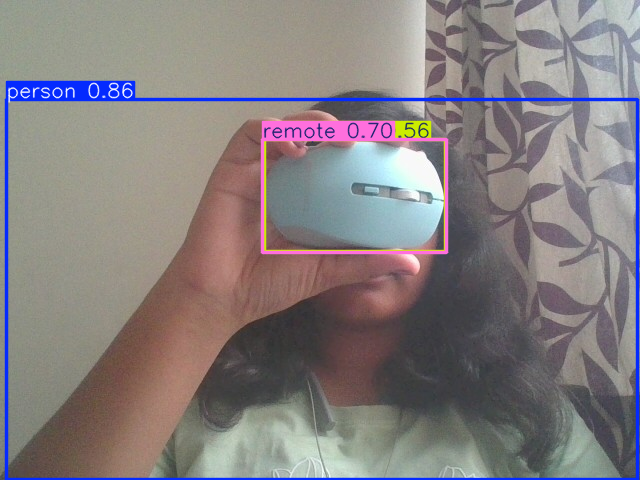

💾 Saved: yolo_output_2.jpg

✅ Done. Saved files: ['yolo_output_1.jpg', 'yolo_output_2.jpg']


In [12]:
max_images = 2
save_prefix = "yolo_output"
saved_files = []

for i in range(max_images):
    print(f"\n📸 Capturing image {i+1}/{max_images} ... (please allow camera if prompted)")
    js_reply = capture_js_image(retries=3)   # will reinject JS if needed
    frame = js_to_image(js_reply)
    if frame is None:
        print("⚠️ Failed to convert JS image to OpenCV. Skipping this capture.")
        continue

    results = model(frame)
    annotated = results[0].plot()
    cv2_imshow(annotated)
    out_path = f"{save_prefix}_{i+1}.jpg"
    cv2.imwrite(out_path, annotated)
    saved_files.append(out_path)
    print(f"💾 Saved: {out_path}")

print("\n✅ Done. Saved files:", saved_files)



image 1/1 /content/image.jpg: 448x640 1 person, 1 bicycle, 1 car, 15.8ms
Speed: 2.9ms preprocess, 15.8ms inference, 4.9ms postprocess per image at shape (1, 3, 448, 640)


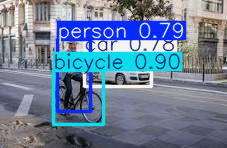

💾 Saved result as yolo_result_from_path.jpg


In [17]:
image_path = "image.jpg"
results = model(image_path)
annotated = results[0].plot()
cv2_imshow(annotated)
output_file = "yolo_result_from_path.jpg"
cv2.imwrite(output_file, annotated)
print(f"💾 Saved result as {output_file}")
